# Fake News Detection

## PySpark Setup

In [1]:
import os
current_directory = os.getcwd()
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/jdk-23.jdk/Contents/Home"  
os.environ["SPARK_HOME"] = os.path.join(current_directory, "spark-3.5.5-bin-hadoop3")

os.environ["PATH"] = os.path.join(os.environ["SPARK_HOME"], "bin") + ":" + os.environ["PATH"]
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"


!pip install -q findspark
!pip install pyspark

import findspark
findspark.init()

import warnings
warnings.filterwarnings("ignore")

## Import packages

In [2]:
# NLP
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.ml.feature import IDF, Tokenizer, VectorAssembler
from pyspark.ml.feature import StopWordsRemover, CountVectorizer
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.functions import when, col, regexp_replace, concat, lit, length
from pyspark.sql.types import FloatType, DoubleType
from pyspark.ml.classification import NaiveBayesModel, NaiveBayes
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [3]:
def evaluate(df, labelCol = "label", predCol = "prediction"):
    TP = df.filter((col(labelCol) == 0) & (col(predCol) == 0)).count()
    FN = df.filter((col(labelCol) == 1) & (col(predCol) == 0)).count()
    FP = df.filter((col(labelCol) == 0) & (col(predCol) == 1)).count()
    TN = df.filter((col(labelCol) == 1) & (col(predCol) == 1)).count()

    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    print("Accuracy: %.3f" % float((TP+TN)/(TP+TN+FP+FN)))
    print("Recall: %.3f" % float(recall))
    print("Precision: %.3f" % float(precision))
    print("F1 Score: %.3f" % float(2*(precision * recall)/(precision +recall)))

    (df
        .crosstab('label','prediction')
        .withColumnRenamed("label_prediction", "label\prediction")
        .orderBy("label\prediction", asceding = False)
        .show()
    )

    return ([[TP, FP], [FN, TN]], precision, recall)

## Spark Session \& Reading Dataset

In [4]:
spark = SparkSession.builder \
    .appName("Model") \
    .master("local[*]") \
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow") \
    .config("spark.executor.extraJavaOptions", "-Djava.security.manager=allow") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

print("Spark Session Created Successfully!")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/06 20:52:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session Created Successfully!


In [5]:
mySchema = StructType([ StructField("index", IntegerType(), True)\
                       ,StructField("title", StringType(), True)\
                       ,StructField("author", StringType(), True)\
                       ,StructField("text", StringType(), True)\
                       ,StructField("label", IntegerType(), True)])

path = "train.csv"
pandas_df = pd.read_csv(path, header = 0)

spark_df = spark.createDataFrame(pandas_df, schema = mySchema)


## Pre-processing

### Cleaning Dataset

In [6]:
# Deleting all rows that are missing text
# df_rmv_nan_text = spark_df.filter(col("text") != "NaN")
df_rmv_nan_text = spark_df.filter(length(col("text")) > 60)

df_no_nan = (df_rmv_nan_text
             .withColumn("title", when(col("title") == "NaN", " ")
                                            .otherwise(col("title")))
             )

# Remove non-character from title and text
df_clean = (df_no_nan

                .withColumn("title", 
                            regexp_replace(
                                col('title'),
                                r'[^\w\’ ]',''))
                
                .withColumn("text", 
                            regexp_replace(
                                col('text'),
                                r'[^\w\’ ]',''))
                
                .withColumn("text", 
                            regexp_replace(
                                col('text'),
                                r'[ ]{2,}',' '))
                
                .withColumn("title", 
                            regexp_replace(
                                col('text'),
                                r'[ ]{2,}',' '))
                )


# Concatenation of title and text 
df_combined = (df_clean
                    .withColumn('full_text',
                                  when(col("text").contains(
                                                    concat(col("title"))),
                                                    col("text"))
                                  
                                  .otherwise(concat(col("title"),
                                                    lit(" "),
                                                    col("text"))))
                    .select(["full_text","label"])
                    .withColumn("label", col("label").cast(DoubleType()))
                    .dropDuplicates()
                )

            
del df_rmv_nan_text, df_no_nan, df_clean

print(df_combined.count())
df_combined.show(7)

20210


+--------------------+-----+
|           full_text|label|
+--------------------+-----+
|0 0 AP N1 26 27 1...|  1.0|
|GREENBELT Md The ...|  0.0|
|The Minnesota off...|  0.0|
|GeoEngineering Un...|  1.0|
|Following a fight...|  0.0|
|The military indu...|  1.0|
|Insists Russia De...|  1.0|
+--------------------+-----+
only showing top 7 rows



### Check Class Balance

In [7]:
df_combined.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|10385|
|  1.0| 9825|
+-----+-----+



### Stopwords

In [7]:
import requests
import os

url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/stopwords.zip"
response = requests.get(url)

nltk_data_path = os.path.expanduser('~/nltk_data/corpora')
os.makedirs(nltk_data_path, exist_ok=True)

with open(os.path.join(nltk_data_path, 'stopwords.zip'), 'wb') as f:
    f.write(response.content)

import nltk
nltk.data.path.append(nltk_data_path)


In [8]:
try:
    stopwords_ls = stopwords.words('english')
except:
    nltk.download("stopwords")
    stopwords_ls = stopwords.words('english')

stopwords_ls[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

### Stemmer Class

In [9]:
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable


class Stemmer(Transformer, 
                 HasInputCol, 
                 HasOutputCol,
                 DefaultParamsReadable, 
                 DefaultParamsWritable):
    
    @keyword_only
    def __init__(self, inputCol = "input", outputCol = "output"):
        super(Stemmer, self).__init__()
        kwargs = self._input_kwargs
        self.set_params(**kwargs)

    @keyword_only
    def set_params(self, inputCol = "input", outputCol = "output"):
        kwargs = self._input_kwargs
        self._set(**kwargs)
    
    def get_input_col(self):
        return self.getOrDefault(self.inputCol)

    def get_output_col(self):
        return self.getOrDefault(self.outputCol)

    def _transform(self, df):

        # Input and output column
        input_col = self.get_input_col()
        output_col = self.get_output_col()

        # Initialize stemmer from nltk package
        ps = PorterStemmer()
        
        # User Defined Function: stemming every word in the input column
        transform_udf = F.udf(lambda x: [ps.stem(word) for word in x], ArrayType(StringType(), False))

        # Return the new df with the new column
        return df.withColumn(output_col, transform_udf(input_col))


# words = Tokenizer(inputCol="text", outputCol="words").transform(spark_df)
# test = Stem(inputCol = "words", outputCol = "test").transform(words)
# test.select(["words", "test"]).show(4)

## Dummy Classifier

In [10]:
df_dummy = (spark_df
                .withColumn("prediction", 
                    when((col("author") == "NaN") | (col("title") == "NaN") , 1.0)
                    .otherwise(0.0))
                .withColumn("label", col("label").cast(FloatType()))
                .select(["label","prediction"])
            )

df_dummy.show(7)

evaluate(df_dummy, predCol = "prediction")

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
+-----+----------+
only showing top 7 rows



Accuracy: 0.618
Recall: 0.567
Precision: 0.997
F1 Score: 0.723


+----------------+-----+----+
|label\prediction|  0.0| 1.0|
+----------------+-----+----+
|             0.0|10361|  26|
|             1.0| 7924|2489|
+----------------+-----+----+



([[10361, 26], [7924, 2489]], 0.9974968710888611, 0.5666393218485097)

## Machine Learning

### Split Data

In [11]:
# Split data to train and test
train, test = df_combined.randomSplit([0.7,0.3], seed=2)

### Pipeline

#### Pipeline Stages


In [12]:
# Stage 1 
tokenizer = Tokenizer(inputCol="full_text", outputCol="full_text_words")

# Stage 2
word_remover = StopWordsRemover(stopWords = stopwords_ls,
                                inputCol = "full_text_words",
                                outputCol = "full_text_words_clean")

# Stage 3 
stemmer = Stemmer(inputCol = "full_text_words_clean", outputCol = "stemmed")

# Stage 4 
tf = CountVectorizer(inputCol="stemmed", outputCol="features", vocabSize = 1e6)

# pipeline = Pipeline(stages= [tokenizer, word_remover, stemmer, tf]).fit(train)
# train_df = pipeline.transform(train).select(["full_text","features","label"])
# test_df = pipeline.transform(test).select(["full_text","features","label"])

In [19]:
!pip uninstall regex -y

Found existing installation: regex 2024.11.6
Uninstalling regex-2024.11.6:
  Successfully uninstalled regex-2024.11.6


In [20]:
!pip install --no-binary=:all: regex


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for regex: filename=regex-2024.11.6-cp311-cp311-macosx_10_9_universal2.whl size=487332 sha256=e1a99523a1f587e28d40fa66dc516d2ebd4d3156147acf44cf86ad6decc912da
  Stored in directory: /Users/bhavyajain/Library/Caches/pip/wheels/d2/74/d3/eb4185974c74e83e12c92aa48754fdf8c9ec0347f67b4056a9
Successfully built regex


In [22]:
import regex
print(regex.__version__)


2.5.148


SyntaxError: invalid syntax (1944833889.py, line 1)

In [23]:
pipeline = Pipeline(stages= [tokenizer, word_remover, stemmer, tf]).fit(train)

#### Save Pipeline

In [25]:
# # #### Save Pipeline! ####
pipeline.save("./model and pipeline/pipeline")

<a name="load"></a>
#### Load Pipeline 

In [27]:
pipeline = PipelineModel.load("./model and pipeline/pipeline")
train_df = pipeline.transform(train).select(["full_text","features","label"])
test_df = pipeline.transform(test).select(["full_text","features","label"])

### Naive Bayes

#### Fit Naive Bayes

In [35]:
nb = NaiveBayes(labelCol="label", featuresCol="features", thresholds = [0.6, 0.4])
nb_model = nb.fit(train_df)
predictions_nb = nb_model.transform(test_df)

<a name="load-na"></a>
#### Load Naive Bayes

In [36]:
nb_model = NaiveBayesModel.load("./model and pipeline/Naive Bayes Model")
predictions_nb = nb_model.transform(test_df)
predictions_nb.select(["label", "prediction"]).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
+-----+----------+
only showing top 20 rows



#### Save Naive Bayes

In [ ]:
nb_model.save("./model and pipeline/Naive Bayes Model")

### Testing

In [37]:
evaluate(predictions_nb.select(["label","prediction"]))

Accuracy: 0.925
Recall: 0.891
Precision: 0.972
F1 Score: 0.930


+----------------+----+----+
|label\prediction| 0.0| 1.0|
+----------------+----+----+
|             0.0|3048|  87|
|             1.0| 372|2616|
+----------------+----+----+



([[3048, 87], [372, 2616]], 0.9722488038277513, 0.8912280701754386)

In [38]:
predictions_dummy_rdd = df_dummy.select(["label", "prediction"]).rdd.map(tuple)
predictions_nb_rdd = predictions_nb.select(["label", "prediction"]).rdd.map(tuple)

# Instantiate metrics object
metrics_dummy = BinaryClassificationMetrics(predictions_dummy_rdd)
metrics_nb = BinaryClassificationMetrics(predictions_nb_rdd)

print("Area under ROC Baseline: " , metrics_dummy.areaUnderROC)
print("Area under ROC Naive Bayes: " , metrics_nb.areaUnderROC)

Area under ROC Baseline:  0.7781506748407558


Area under ROC Naive Bayes:  0.9295208053429913


# Result

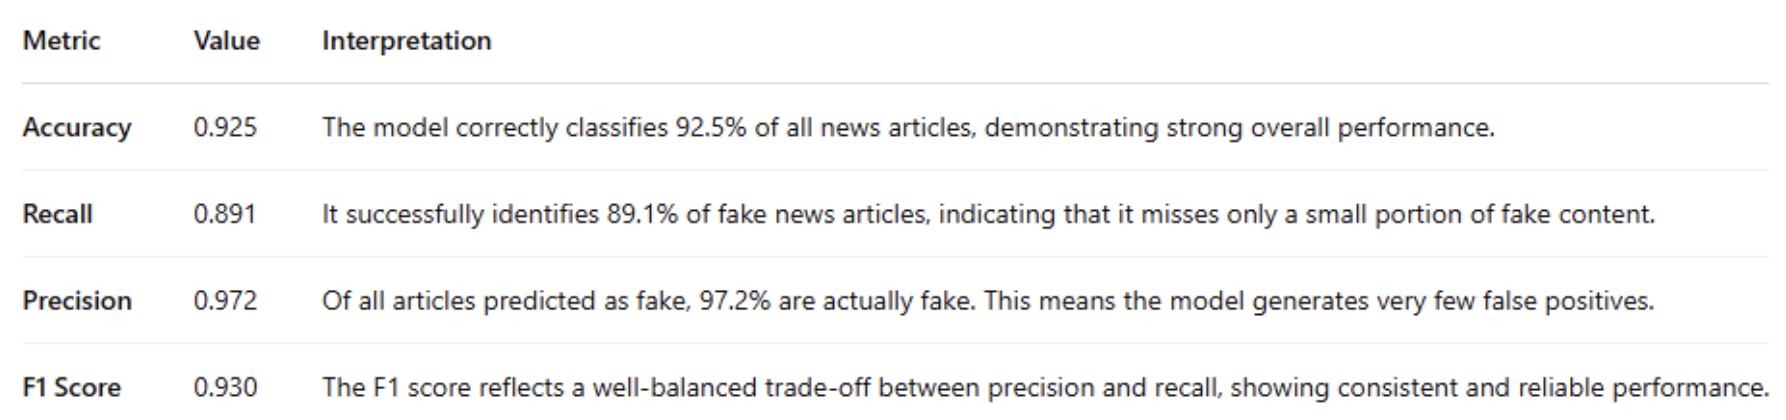